# Tutorial

In the following, we assume that you have already set up your environment as described in the [README](README.md).


In [1]:
import os

assert os.path.exists(
    "exputils/dot/fast_dot_products.exe"
), "Please compile the fast_dot_products.cpp first"

## Introduction

This tutorial will show you how to calculate the RoM of a given state.

As a byproduct, you will also see how to generate all the pure stabilizer states in Pauli basis, and how to calculate the stabilizer fidelity of a given state.


## A matrix

The A matrix is defined as the set of all pure stabilizer states in Pauli basis.

We can express a pure stabilizer state by a subgroup of Pauli group.
For example, the stabilizer state $(|00\rangle + |11\rangle)/\sqrt{2}$ can be expressed by the subgroup $\{II, XX, -YY, ZZ\}$, as stated in [here](https://quantumcomputing.stackexchange.com/questions/18235/what-is-a-stabilizer-state).

You can find that the 39th column in the A matrix of $n=2$ is actually corresponding to this stabilizer state.

![A matrix of 1 and 2 qubit](https://github.com/quantum-programming/RoM-handbook/blob/e968ec17478ff1855478d42e4b5d949dda76c4a3/doc/summary/imgs/Amat.png?raw=true)


In [2]:
import numpy as np
from exputils.actual_Amat import get_actual_Amat

# This function loads the Amat from the data folder
n = 1  # 1 <= n <= 5
Amat1 = get_actual_Amat(n).toarray()
print(Amat1)

[[ 1  1  1  1  1  1]
 [ 1 -1  0  0  0  0]
 [ 0  0  1 -1  0  0]
 [ 0  0  0  0  1 -1]]


In [3]:
from exputils.dot.get_topK_botK_Amat import get_topK_botK_Amat

# This function generates the Amat, without loading any data
n = 1  # 1 <= n <= 8, but since Amat is a very large matrix, n>=6 is not recommended
dummy_rho_vec = np.zeros(4**n)
print(get_topK_botK_Amat(n, dummy_rho_vec, 1.0, False, True, False).toarray())

[[ 1  1  1  1  1  1]
 [ 0  0  1 -1  0  0]
 [ 0  0  0  0  1 -1]
 [ 1 -1  0  0  0  0]]


## b vector

We also convert a given density matrix into a vector in Pauli basis, which is called b vector or $\rho$ vector.


In [4]:
import qutip
from exputils.state.state_in_pauli_basis import state_in_pauli_basis

# Pauli matrices
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0, -1j], [1j, 0]])

n_qubit = 1

# the state we are interested in
state = qutip.rand_dm_ginibre(2**n_qubit, seed=0).full()

print("density matrix:", state, sep="\n", end="\n\n")

# in naive way (definition)
rho_vec_def = np.array(
    [np.trace(state @ pauli_matrix) for pauli_matrix in [I, X, Y, Z]]
)
print("state in pauli basis (definition):", rho_vec_def, sep="\n", end="\n\n")

# in fast way (See the appendix of the paper for the details)
rho_vec = state_in_pauli_basis(state)
print("state in pauli basis (function):", rho_vec, sep="\n")

assert np.allclose(rho_vec_def, rho_vec), "rho_vec_def != rho_vec"

density matrix:
[[0.63280184-5.91216718e-18j 0.2389964 +3.24793793e-01j]
 [0.2389964 -3.24793793e-01j 0.36719816+5.91216718e-18j]]

state in pauli basis (definition):
[ 1.        +0.00000000e+00j  0.47799281+0.00000000e+00j
 -0.64958759+0.00000000e+00j  0.26560369-1.18243344e-17j]

state in pauli basis (function):
[ 1.          0.47799281 -0.64958759  0.26560369]


## RoM

The RoM is defined as the optimal solution of the following optimization problem:

$$
\begin{align*}
\text{minimize}_{\boldsymbol{x}} & ||\boldsymbol{x}||_1 \\
     \text{ subject to } & \boldsymbol{A} \boldsymbol{x}= \boldsymbol{b}
\end{align*}
$$

This is equivalent to the following LP problem:

$$
\begin{align*}
\text{minimize}_{\boldsymbol{u}} & \sum_{i} u_i \\
     \text{ subject to } & \begin{pmatrix} \boldsymbol{A}_{n} & -\boldsymbol{A}_{n} \end{pmatrix} \boldsymbol{u} = \boldsymbol{b} \\
                         & \boldsymbol{u} \geq 0
\end{align*}
$$


In [5]:
from scipy.optimize import linprog

A_and_minus_A = np.hstack([Amat1, -Amat1])

sz = Amat1.shape[1]  # = |S_n| = 2^n \prod_{i=1}^{n} (2^n+1) = 6

res = linprog(
    c=np.ones(2 * sz),
    A_eq=A_and_minus_A,
    b_eq=rho_vec,
    bounds=[0, None],
)

quasi_prob = res.x[:sz] - res.x[sz:]

print("optimal value (RoM):", res.fun)
print("quasi probabilities:", quasi_prob)

assert np.allclose(res.fun, np.linalg.norm(quasi_prob, ord=1))
assert np.allclose(Amat1 @ quasi_prob, rho_vec)

optimal value (RoM): 1.3931840770273858
quasi probabilities: [ 0.47799281  0.          0.          0.64958759  0.06901165 -0.19659204]


In this method (naive LP), we can compute the RoM up to $n=5$.

Now, we will show you how to calculate the RoM up to $n=8$.


## Relationship to the inner product

The quasi-probability distribution has a relationship to the inner product of each stabilizer state and the given state.

Thus, we can utilize the inner product to calculate the RoM.


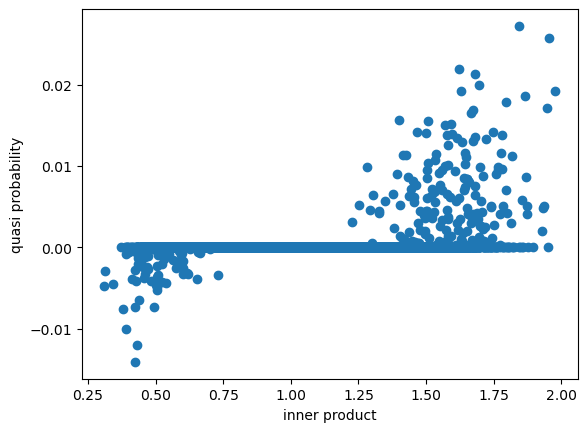

In [6]:
from exputils.RoM.custom import calculate_RoM_custom
from exputils.state.random import make_random_quantum_state
import matplotlib.pyplot as plt


Amat4 = get_actual_Amat(4)
rho_vec = make_random_quantum_state("mixed", n_qubit=4, seed=0)

inner_products = rho_vec @ Amat4

quasi_prob = calculate_RoM_custom(Amat4, rho_vec)[1]

plt.scatter(inner_products, quasi_prob)
plt.xlabel("inner product")
plt.ylabel("quasi probability")
plt.show()

## FWHT for the inner product

The inner product can be calculated by the fast Walsh-Hadamard transform (FWHT).

### FWHT

Firstly, we show the FWHT itself. The Walsh Hadamard matrix is defined as follows:

$$
\begin{align*}
    \boldsymbol{H}_1 &= \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} \\
  \boldsymbol{H}_{n} &= \boldsymbol{H}_{n-1} \otimes \boldsymbol{H}_1 \; (n \geq 2)
\end{align*}
$$


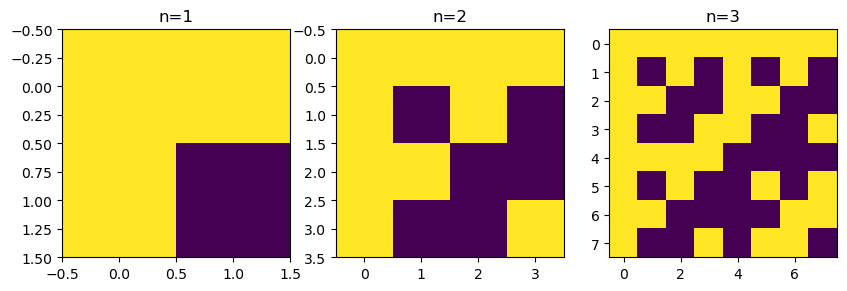

In [7]:
from exputils.math.fwht import sylvesters

fig = plt.figure(figsize=(10, 3))
for n in range(1, 3 + 1):
    ax = fig.add_subplot(1, 3, n)
    walsh = sylvesters(n)
    ax.imshow(walsh)
    ax.set_title(f"{n=}")

In [8]:
from exputils.math.fwht import FWHT

n = 2
walsh = sylvesters(n)
vec = np.array([1.0, 2.0, 3.0, 4.0])

print("                   normal matrix product", walsh @ vec)
print("product by Fast Walsh Hadamard Transform", FWHT(n, vec) * (2**n))

                   normal matrix product [10. -2. -4.  0.]
product by Fast Walsh Hadamard Transform [10. -2. -4.  0.]


### Application to the inner product

By using FWHT, we can compute the inner products very speedily.


In [9]:
from exputils.dot.get_topK_botK_Amat import get_topK_botK_Amat

n_qubit, K = (4, 1e-1)
# n_qubit, K = (5, 1e-2)
# n_qubit, K = (6, 1e-3)
# n_qubit, K = (7, 1e-5)
# n_qubit, K = (8, 1e-8)

rho_vec = make_random_quantum_state("mixed", n_qubit, seed=0)

# the topK and botK of Amat (in the sense of inner product with rho_vec)
Amat = get_topK_botK_Amat(
    n_qubit, rho_vec, K, is_dual=False, is_random=False, verbose=True
)

start to calculate with C++
[start] n_qubit: 4 K: 0.1000000000
 total time: 3[ms]
----- the obtained value ranges -----
 max of topK: 1.9775861350
 min of topK: 1.3892873093
 max of botK: 0.6563224827
 min of botK: 0.3112466224
[start] restore the Amat... done
finish to calculate with C++


We can confirm that the results by the function are surely the same as the results by the normal calculation.


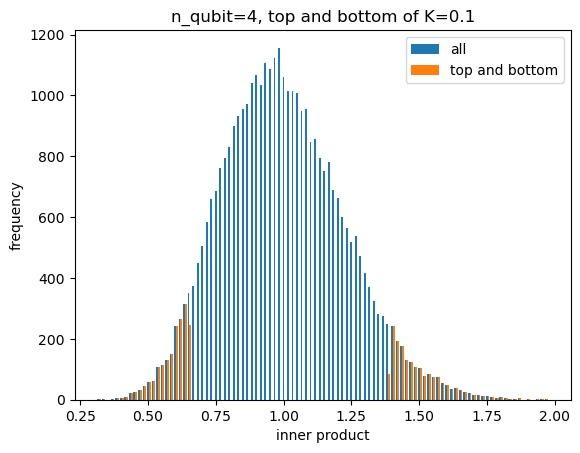

In [10]:
plt.hist(
    [rho_vec @ get_actual_Amat(n_qubit), rho_vec @ Amat],
    bins=100,
    label=["all", "top and bottom"],
)
plt.xlabel("inner product")
plt.ylabel("frequency")
plt.legend()
plt.title(f"{n_qubit=}, top and bottom of {K=}")
plt.show()

## Approximate calculation of RoM

By using the matrix obtained by the FWHT, we can calculate the RoM approximately,
which is very near to the exact RoM.


In [11]:
print("== approximate solution ===")
print(calculate_RoM_custom(Amat, rho_vec))

== approximate solution ===
(1.3796759521106376, array([0.00128977, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ]))


In [12]:
from exputils.RoM.actual import calculate_RoM_actual


print("=== exact solution ===")
print(calculate_RoM_actual(n_qubit, rho_vec))

=== exact solution ===
(1.376209751003376, array([0., 0., 0., ..., 0., 0., 0.]))


## Exact RoM

To the end, we use Column Generation(CG) method to calculate the exact RoM.

The following code requires [Gurobi](https://www.gurobi.com/) to be installed for $n \geq 5$.

Gurobi is a commercial optimization solver, but it can be used for free for academic purposes.


start to calculate with C++
[start] n_qubit: 4 K: 0.1000000000
 total time: 3[ms]
----- the obtained value ranges -----
 max of topK: 1.9775861350
 min of topK: 1.3892873093
 max of botK: 0.6563224827
 min of botK: 0.3112466224
[start] restore the Amat... done
finish to calculate with C++
turn 1: RoM:1.3796759521106376
start to calculate with C++
[start] n_qubit: 4 K: 0.1000000000
 total time: 1[ms]
----- the obtained value ranges -----
 max of topK: 1.1716400261
 min of topK: 0.8000714276
 violated_count: 134
[start] restore the Amat... done
finish to calculate with C++
# of violation: 41 
turn 2: RoM:1.3762149101243024
start to calculate with C++
[start] n_qubit: 4 K: 0.1000000000
 total time: 1[ms]
----- the obtained value ranges -----
 max of topK: 1.0120347899
 min of topK: 0.8002428041
 violated_count: 91
[start] restore the Amat... done
finish to calculate with C++
# of violation: 5 
turn 3: RoM:1.3762097510031583
start to calculate with C++
[start] n_qubit: 4 K: 0.1000000000
 t

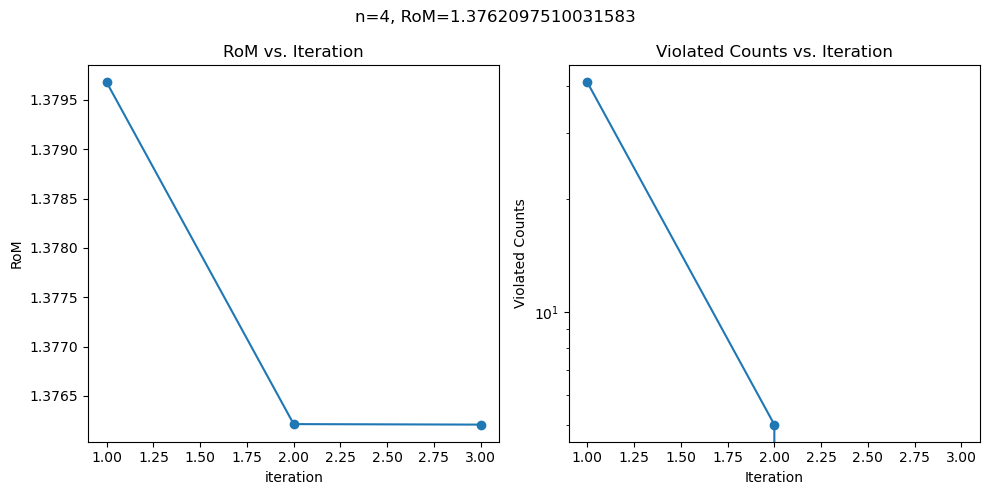

start to calculate with C++
[start] n_qubit: 4 K: 0.0000000000
init topK_value: 1.0000000000

 total time: 0[ms]
----- the obtained value ranges -----
 max of topK: 1.0000000001
 min of topK: 1.0000000001
 violated_count: 95
[start] restore the Amat... done
finish to calculate with C++
=== CG solution ===
1.3762097510031583
=== exact solution ===
1.376209751003376


In [13]:
import scipy.sparse


def vis_hist(n, RoM, RoM_hist, violations_hist):
    assert len(RoM_hist) == len(violations_hist)
    it = list(range(1, len(RoM_hist) + 1))
    fig = plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(it, RoM_hist, "o-")
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("RoM")
    ax1.set_title("RoM vs. Iteration")
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(it, violations_hist, "o-")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Violated Counts")
    ax2.set_yscale("log")
    ax2.set_title("Violated Counts vs. Iteration")
    fig.suptitle(f"{n=}, {RoM=}")
    plt.tight_layout()
    plt.show()


def CG(n, K, rho_vec):
    eps = 1e-10
    discard_current_threshold = 0.8
    iter_max = 100

    cur_A = get_topK_botK_Amat(n, rho_vec, K, is_dual=False, is_random=False)

    RoM_hist = []
    violations_hist = []
    got_Amat = None
    ret = None
    for i in range(1, iter_max + 1):
        RoM, coeff, dual = calculate_RoM_custom(
            cur_A,
            rho_vec,
            verbose=True,
            method="scipy",
            # method="gurobi", # for n \geq 5
            return_dual=True,
            crossover=False,
        )
        print(f"turn {i}: RoM:{RoM}")
        RoM_hist.append(RoM)

        got_Amat = get_topK_botK_Amat(n, dual, K, is_dual=True, is_random=False)
        dual_dots = np.abs(dual.T @ got_Amat)
        dual_violated_indices = dual_dots > 1 + eps
        indices = np.where(dual_violated_indices)[0]
        extra_Amat = got_Amat[:, indices]

        violations_hist.append(extra_Amat.shape[1] if np.min(dual_dots) < 1 else np.nan)
        print(
            f"# of violation: {extra_Amat.shape[1]}",
            "and more" if np.min(dual_dots) >= 1 else "",
        )
        if extra_Amat.shape[1] == 0:
            ret = (RoM, cur_A, coeff, dual)
            break

        nonbasic_indices = np.abs(coeff) > eps
        critical_indices = np.abs(dual @ cur_A) >= discard_current_threshold
        remain_indices = np.logical_or(nonbasic_indices, critical_indices)
        cur_A = scipy.sparse.hstack((cur_A[:, remain_indices], extra_Amat))

    if ret is None:
        assert False, "failed CG"

    RoM, cur_A, coeff, dual = ret
    vis_hist(n, RoM, RoM_hist, violations_hist)

    return RoM, cur_A, coeff, dual


n, K = 4, 1e-1
# n, K = 5, 1e-2
# n, K = 6, 1e-3
# n, K = 7, 1e-5
# n, K = 8, 1e-8

rho_vec = make_random_quantum_state("mixed", n, seed=0)
RoM, cur_A, coeff, dual = CG(n, K, rho_vec)

# check the constraints, Ax = b
assert np.allclose(cur_A @ coeff, rho_vec)

# check the optimality condition, A^T y <= 1
max_violated_matrix = get_topK_botK_Amat(n, dual, 0, is_dual=True, is_random=False)
should_be_less_1 = np.abs(dual.T @ max_violated_matrix)
assert np.max(should_be_less_1) <= 1 + 1e-10

# check with the naive solution
print("=== CG solution ===")
print(RoM)
print("=== exact solution ===")
print(calculate_RoM_actual(n, rho_vec)[0])

## To End

Now we can compute the RoM utilizing the inner products!

For more details, please see the each function's implementation and notebooks in the `doc/summary` directory.

We hope you enjoy the RoM calculation!


## Appendix

### How to compute stabilizer fidelity

It is easy to compute the stabilizer fidelity by using the algorithm we provided, since stabilizer fidelity is corresponding to the maximum value of the inner product.


In [14]:
n_qubit = 4
K = 0.0

rho_vec = make_random_quantum_state("mixed", n_qubit, seed=0)
Amat = get_topK_botK_Amat(
    n_qubit, rho_vec, K, is_dual=False, is_random=False, verbose=True
)
dot_max = np.max(rho_vec.T @ Amat)

print(f"{dot_max=}")

start to calculate with C++
[start] n_qubit: 4 K: 0.0000000000
init topK_value: 1.9533782696, init botK_value: 0.3129803391

 total time: 0[ms]
----- the obtained value ranges -----
 max of topK: 1.9775861350
 min of topK: 1.9775861350
 max of botK: 0.3112466224
 min of botK: 0.3112466224
[start] restore the Amat... done
finish to calculate with C++
dot_max=1.977586134950716


In "Simulation of quantum circuits by low-rank stabilizer decompositions"

(Sergey Bravyi, Dan Browne, Padraic Calpin, Earl Campbell, David Gosset, and Mark Howard)

It is said that $F(T) \approx 0.853$.

We confirm this.


In [15]:
from exputils.state.tensor import make_random_tensor_product_state
from exputils.actual_Amat import get_actual_Amat

n_qubit = 1
rho_vec = make_random_tensor_product_state("H", n_qubit, seed=0)
Amat = get_actual_Amat(n_qubit)
dots = rho_vec.T @ Amat
dot_max = np.max(dots)  # we can also obtain this by get_topK_botK_Amat

stabilizer_fidelity = dot_max / (2**n_qubit)
print(stabilizer_fidelity)

0.8535533905932737
